<a href="https://colab.research.google.com/github/alvinrach/Product-Recommender-System/blob/main/English_Product_Recommender_Alvin_Rachmat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Data with Kaggle API

Make sure you're signed up for Kaggle and know how to get credentials to run the Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"alvinrach","key":"01d0bc7e09928966a5b93eabab748737"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ruchi798/marketing-bias-in-product-recommendations

 55% 7.00M/12.7M [00:00<00:00, 72.4MB/s]
100% 12.7M/12.7M [00:00<00:00, 79.1MB/s]


Unzip the downloaded data

In [ ]:
!unzip /content/marketing-bias-in-product-recommendations.zip

Archive:  /content/marketing-bias-in-product-recommendations.zip
  inflating: electronics.csv         
  inflating: modcloth.csv            


# Import Required Packages

Import the required dependencies

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

Here is the data used

In [ ]:
d = pd.read_csv('/content/electronics.csv')
d

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0
3,0,3,1.0,1999-07-01,Female,Portable Audio & Video,NaN,1999,NaN,0
4,0,4,2.0,1999-07-06,Female,Portable Audio & Video,NaN,1999,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1292949,9478,1157628,1.0,2018-09-26,Female,Headphones,Etre Jeune,2017,NaN,0
1292950,9435,1157629,5.0,2018-09-26,Female,Computers & Accessories,NaN,2017,NaN,0
1292951,9305,1157630,3.0,2018-09-26,Female,Computers & Accessories,NaN,2016,NaN,0
1292952,9303,1157631,5.0,2018-09-29,Male,Headphones,NaN,2018,NaN,0


Check for duplicated data. There is no duplicated data

In [ ]:
d[d.duplicated()]

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split


Checking for null values and datatype

In [ ]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292954 entries, 0 to 1292953
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   item_id     1292954 non-null  int64  
 1   user_id     1292954 non-null  int64  
 2   rating      1292954 non-null  float64
 3   timestamp   1292954 non-null  object 
 4   model_attr  1292954 non-null  object 
 5   category    1292954 non-null  object 
 6   brand       331120 non-null   object 
 7   year        1292954 non-null  int64  
 8   user_attr   174124 non-null   object 
 9   split       1292954 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 98.6+ MB


Checking the split feature

In [ ]:
d.split.value_counts()

0    1169809
2     102810
1      20335
Name: split, dtype: int64

View the number of items in the dataset. There are 9560 items

In [ ]:
len(d.item_id.unique())

9560

View the number of users in the dataset. There are 1157633 total users

In [ ]:
len(d.user_id.unique())

1157633

View the number of categories

In [ ]:
len(d.category.unique())

10

See the various brands that exist

In [ ]:
d.brand.unique()

array([nan, 'HP', 'Philips', 'Polaroid', 'Panasonic', 'JVC', 'Fujifilm',
       'Nikon', 'Kodak', 'Sony', 'Canon', 'Kensington', 'Pyle', 'Olympus',
       'Toshiba', 'Logitech', 'Etre Jeune', 'Linksys', 'Vivitar',
       'Sennheiser', 'Apple', 'Samsung', 'EldHus', 'Bose', 'Archos',
       'Garmin', 'Jabra', 'Gary Fong', 'ViewSonic', 'Savage', 'Uniden',
       'ebasy', 'Generic', 'JLAB', 'Skullcandy', 'TaoTronics', 'Neewer',
       'Koolertron', 'DURAGADGET', 'iRULU', 'Tiamat', 'DBPOWER', 'Fintie',
       'Plemo', 'EINCAR', 'Cooper Cases', 'LSS', 'Mpow', 'XShields',
       'IRULU', 'Funlux'], dtype=object)

View the number of brands

In [ ]:
len(d.brand.unique())

51

View rating distribution

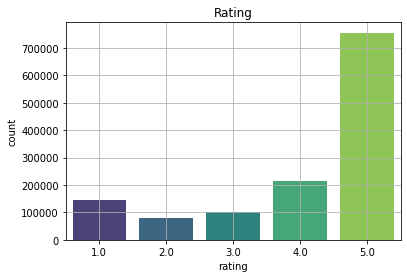

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='rating', data=d, palette='viridis')
plt.title('Rating')
plt.grid();

Visualize the gender assignment of an item

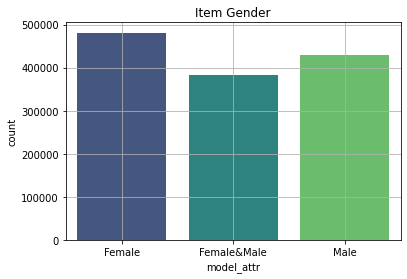

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x='model_attr', data=d, palette='viridis')
plt.title('Item Gender')
plt.grid();

Distribusi kategori

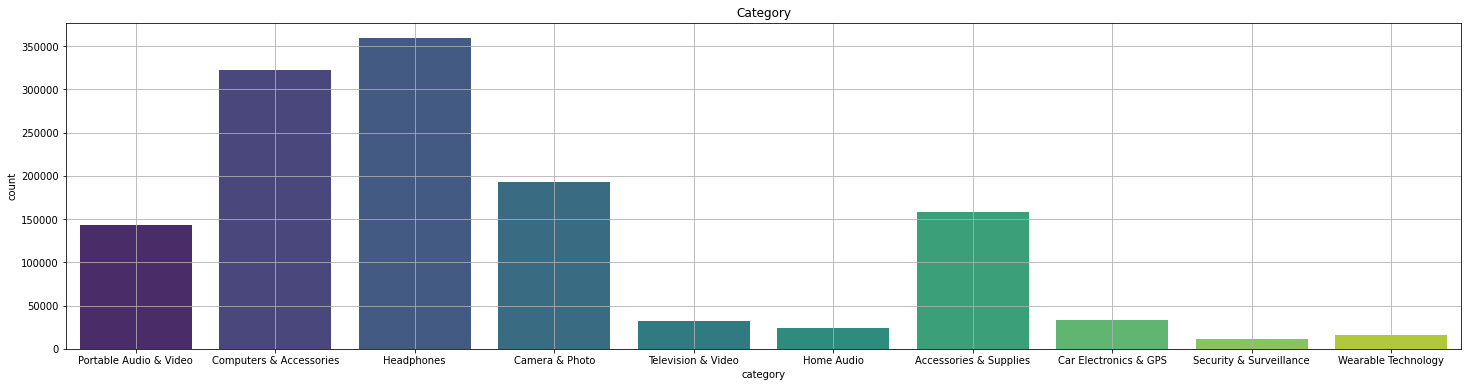

In [ ]:
fig, ax = plt.subplots(figsize=(25,6))
sns.countplot(x='category', data=d, palette='viridis')
plt.title('Category')
plt.grid();

Release year distribution

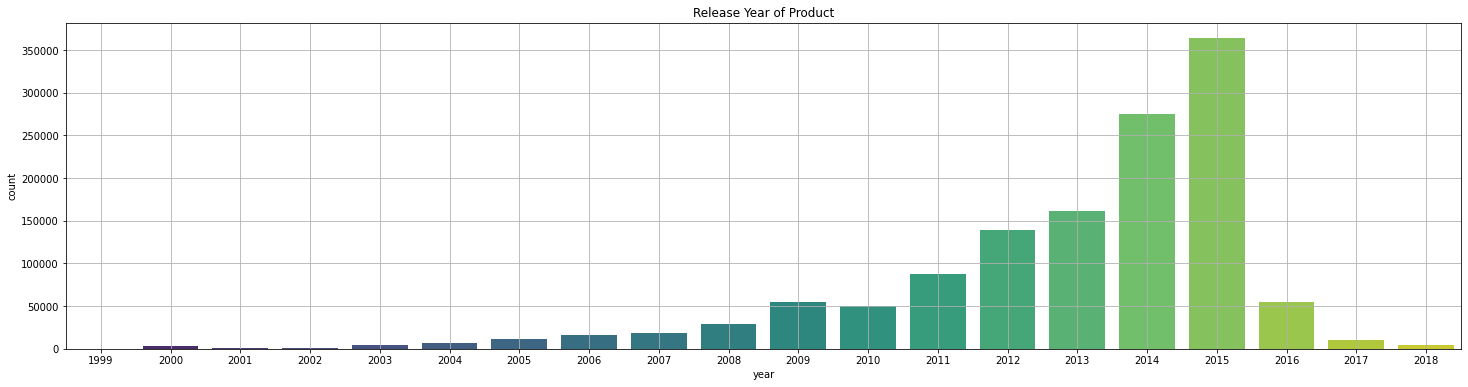

In [ ]:
fig, ax = plt.subplots(figsize=(25,6))
sns.countplot(x='year', data=d, palette='viridis')
plt.title('Release Year of Product')
plt.grid();

View the items with the highest occurrence frequency

In [ ]:
d.item_id.value_counts()

7780    28530
2031     9393
1575     8622
2279     6278
2486     5810
        ...  
9555        1
1529        1
9557        1
4253        1
3972        1
Name: item_id, Length: 9560, dtype: int64

View the users with the highest occurrence frequency

In [ ]:
d.user_id.value_counts()

142967    41
30661     38
89185     37
80476     34
46878     34
          ..
702412     1
692171     1
696265     1
694216     1
0          1
Name: user_id, Length: 1157633, dtype: int64

# Content-Based Filtering

Selecting data for content-based filtering. The data used are item_id, model_attr, category, brand and year. In addition, null values were also filled in brand features, and dummy was also performed. Next, groubpy is done using the average technique

In [ ]:
f = d[['item_id','model_attr','category','brand','year']]
f.brand = f.brand.fillna('unbranded')
f.year = f.year.astype('str')
f = pd.get_dummies(f)
f = f.groupby('item_id').mean()
f.tail(6)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,model_attr_Female,model_attr_Female&Male,model_attr_Male,category_Accessories & Supplies,category_Camera & Photo,category_Car Electronics & GPS,category_Computers & Accessories,category_Headphones,category_Home Audio,category_Portable Audio & Video,category_Security & Surveillance,category_Television & Video,category_Wearable Technology,brand_Apple,brand_Archos,brand_Bose,brand_Canon,brand_Cooper Cases,brand_DBPOWER,brand_DURAGADGET,brand_EINCAR,brand_EldHus,brand_Etre Jeune,brand_Fintie,brand_Fujifilm,brand_Funlux,brand_Garmin,brand_Gary Fong,brand_Generic,brand_HP,brand_IRULU,brand_JLAB,brand_JVC,brand_Jabra,brand_Kensington,brand_Kodak,brand_Koolertron,brand_LSS,brand_Linksys,brand_Logitech,...,brand_Panasonic,brand_Philips,brand_Plemo,brand_Polaroid,brand_Pyle,brand_Samsung,brand_Savage,brand_Sennheiser,brand_Skullcandy,brand_Sony,brand_TaoTronics,brand_Tiamat,brand_Toshiba,brand_Uniden,brand_ViewSonic,brand_Vivitar,brand_XShields,brand_ebasy,brand_iRULU,brand_unbranded,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9554,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9555,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9556,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9557,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9558,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9559,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Doing checks that show groupby on average is successful or not, indicated by unique values only 0 and 1. If there is a float, it indicates that the data item is inconsistent

In [ ]:
for i in f:
  print(f[i].unique())

[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


Search for similarities between items using cosine_similarity

In [ ]:
cosine_sim = cosine_similarity(f)
cosine_sim_df = pd.DataFrame(cosine_sim, index=f.index, columns=f.index)
cosine_sim_df

item_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9520,9521,9522,9523,9524,9525,9526,9527,9528,9529,9530,9531,9532,9533,9534,9535,9536,9537,9538,9539,9540,9541,9542,9543,9544,9545,9546,9547,9548,9549,9550,9551,9552,9553,9554,9555,9556,9557,9558,9559
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.25,0.25,0.50,0.25,0.00,0.25,0.25,0.50,0.25,0.50,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.25,0.25,0.00,0.25,0.50,0.25,0.25,0.25,0.25,0.25,0.00,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.50,0.25,...,0.25,0.50,0.50,0.50,0.50,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.00,0.50,0.25,0.00,0.50,0.50,0.25,0.25,0.50,0.50,0.50,0.75,0.50,0.25,0.00,0.50,0.25,0.25,0.00,0.25,0.25,0.25,0.25
1,0.25,1.00,0.25,0.25,0.50,0.25,0.25,0.25,0.50,0.25,0.25,0.00,0.00,0.50,0.00,0.00,0.00,0.25,0.25,0.50,0.00,0.25,0.25,0.00,0.25,0.25,0.25,0.25,0.00,0.00,0.25,0.00,0.25,0.00,0.25,0.25,0.25,0.25,0.50,0.25,...,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.00,0.50,0.50,0.00,0.00,0.25,0.25,0.00,0.25,0.25,0.00,0.25,0.25,0.00,0.50,0.25,0.25,0.00,0.25,0.25,0.00,0.25,0.25,0.00,0.25,0.25,0.00,0.25,0.25,0.00,0.25,0.00,0.00
2,0.25,0.25,1.00,0.25,0.25,0.50,0.00,0.00,0.50,0.00,0.50,0.00,0.25,0.25,0.25,0.25,0.25,0.00,0.00,0.25,0.25,0.25,0.25,0.50,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.50,0.00,0.25,0.00,0.00,0.00,0.00,0.25,0.00,...,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.50,0.25,0.00,0.75,0.25,0.25,0.25,0.50,0.50,0.25,0.50,0.25,0.25,0.25,0.25,0.50,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.50,0.00,0.25,0.50,0.25,0.00,0.25,0.25,0.50,0.50
3,0.50,0.25,0.25,1.00,0.25,0.25,0.50,0.25,0.50,0.50,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.50,0.50,0.50,0.25,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.25,0.25,0.50,0.50,0.50,0.00,0.50,0.50,0.50,0.50,0.50,0.50,...,0.50,0.75,0.50,0.50,0.50,0.25,0.50,0.50,0.50,0.25,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.00,0.50,0.25,0.00,0.50,0.50,0.25,0.50,0.75,0.75,0.25,0.50,0.50,0.50,0.00,0.75,0.50,0.25,0.00,0.00,0.25,0.50,0.25
4,0.25,0.50,0.25,0.25,1.00,0.25,0.25,0.50,0.50,0.25,0.25,0.00,0.00,0.50,0.00,0.00,0.00,0.25,0.25,0.50,0.00,0.00,0.25,0.00,0.25,0.25,0.25,0.25,0.00,0.00,0.25,0.00,0.25,0.00,0.25,0.25,0.25,0.25,0.25,0.25,...,0.00,0.25,0.50,0.25,0.25,0.00,0.00,0.00,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.25,0.25,0.00,0.00,0.25,0.25,0.00,0.25,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9555,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,...,0.25,0.00,0.25,0.25,0.00,0.50,0.25,0.25,0.50,0.25,0.00,0.25,0.75,0.75,0.25,0.50,0.75,0.00,0.25,0.75,0.50,0.50,0.25,0.75,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.75,0.25,0.25,0.75,1.00,0.25,0.75,0.25,0.50
9556,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.25,0.25,0.00,0.25,0.00,0.25,0.25,0.25,0.00,0.00,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.25,0.25,0.00,0.25,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.50,0.00,0.25,0.25,0.00,0.00,0.00,0.50,0.25,0.00,0.25,0.00,0.25,0.25,0.50,0.50,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.25,0.50,0.25,0.25,0.50,0.25,0.25,1.00,0.25,0.50,0.25
9557,0.25,0.25,0.25,0.25,0.00,0.00,0.00,0.00,0.25,0.25,0.50,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.75,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,...,0.50,0.25,0.50,0.50,0.25,0.75,0.50,0.50,0.75,0.25,0.25,0.50,1.00,1.00,0.50,0.75,1.00,0.00,0.50,1.00,0.50,0.75,0.50,1.00,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.50,1.00,0.75,0.25,1.00,0.50,0.75


## Recommendation

Created a function to issue 10 recommendation outputs. Don't forget to choose items randomly

In [ ]:
item_id = pd.Series(f.index).sample(1).iloc[0]

def recommendations(item_id=item_id, threshold=0.7, n_item=10):
  print(f'Showing similar item for item {item_id}')
  print()
  a = np.argsort(cosine_sim_df[item_id].values)
  a = a[~np.isin(a,item_id)]
  a = a[-n_item:][::-1]
  a = {i:cosine_sim_df[item_id][i] for i in a}
  a

  b=0
  for i,j in a.items():
    if j>threshold:
      b+=1
    print('Item', i, '|', 'Cosine Similarity Value :', j)
  print()

  c = b*100/n_item
  print('Precision (%):')
  return c

Recommended 10 similar items for users who choose item 2360 as well, along with its cosine_similarity value

In [ ]:
recommendations(item_id)

Showing similar item for item 2360

Item 2257 | Cosine Similarity Value : 1.0
Item 2218 | Cosine Similarity Value : 0.75
Item 1610 | Cosine Similarity Value : 0.75
Item 2070 | Cosine Similarity Value : 0.75
Item 2443 | Cosine Similarity Value : 0.75
Item 2086 | Cosine Similarity Value : 0.75
Item 2116 | Cosine Similarity Value : 0.75
Item 2122 | Cosine Similarity Value : 0.75
Item 2124 | Cosine Similarity Value : 0.75
Item 2373 | Cosine Similarity Value : 0.75

Precision (%):


100.0

## Evaluation

With the same function (without print output), create a derivative function to measure precision, where the precision of the recommendation system is the number of appropriate data divided by the number of recommendations that appear. Then it is repeated a number of n_to_eval to further averaged.

In [ ]:
def _evalRecommendations(item_id=item_id, threshold=0.7, n_item=10):
  a = np.argsort(cosine_sim_df[item_id].values)
  a = a[~np.isin(a,item_id)]
  a = a[-n_item:][::-1]
  a = {i:cosine_sim_df[item_id][i] for i in a}
  a

  b=0
  for i,j in a.items():
    if j>threshold:
      b+=1

  c = b*100/n_item
  return c

An evaluation function that outputs one by one is then inserted into the loop function and looped n_to_eval times, each time using an random number of item_id

In [ ]:
def evalRecommendations(n_to_eval=100):
  a = 0
  for i in range(n_to_eval):
    item_id = pd.Series(f.index).sample(1).iloc[0]
    a = a + _evalRecommendations(item_id)

  print(f'Evaluation (Precision) for {n_to_eval} times try is : {a/n_to_eval} %')

Outputs precision values in the content-based filtering recommendation system

In [ ]:
evalRecommendations(100)

Evaluation (Precision) for 100 times try is : 99.8 %


# Collaborative Filtering

Selecting attributes and target variables. The attributes used are user_id and item_id, while the target variable is rating. In addition, the data is divided into 80% training data and 20% test data and using min-max scaling on the target variable, with a note that the fit scaling is only done on the training data.

In [ ]:
x = d[['user_id','item_id']].values
y = d['rating'].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.8, random_state=42)

min_rating = min(y_train)
max_rating = max(y_train)

minmax = lambda x: (x - min_rating) / (max_rating - min_rating)
y_train = np.array([minmax(x) for x in y_train])
y_val = np.array([minmax(x) for x in y_val])

print(x_train, y_train)

[[ 45069   1301]
 [ 57222   1421]
 [264204    452]
 ...
 [125133   1435]
 [610433   5580]
 [115777   1473]] [1.   1.   0.75 ... 0.   0.5  1.  ]


Stores the number of users, items, minimum and maximum rating values in variables

In [ ]:
num_users = len(d.user_id.unique())
num_items = len(d.item_id.unique())

print('Number of User: {}, Number of Item: {}, Min Rating Train: {}, Max Rating Train: {}'.format(
    num_users, num_items, min_rating, max_rating
))

Number of User: 1157633, Number of Item: 9560, Min Rating Train: 1.0, Max Rating Train: 5.0


Designing the model architecture, using embedding techniques, and also using bias

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  def __init__(self, num_users, num_items, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_items = num_items
    self.embedding_size = embedding_size

    self.user_embedding = layers.Embedding( # user embedding layer
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # bias of user embedding layer

    self.item_embedding = layers.Embedding( # item embedding layer
        num_items,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )

    self.item_bias = layers.Embedding(num_items, 1) # bias of item embedding layer

  def call(self, inputs): # calling the embedding layers
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    item_vector = self.item_embedding(inputs[:, 1])
    item_bias = self.item_bias(inputs[:, 1])
 
    dot_user_item = tf.tensordot(user_vector, item_vector, 2)
 
    x = dot_user_item + user_bias + item_bias

    return tf.nn.sigmoid(x)

Call the model and compile it. Used Adam optimizer and RMSE metric

In [ ]:
model = RecommenderNet(num_users, num_items, 50)
 
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0005),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Set the callback you want to use. Here we use EarlyStopping which is useful for stopping when there is no performance improvement and ModelCheckpoint to record the model at the best epoch

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=5)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.tf',
    monitor = 'val_root_mean_squared_error',
    save_best_only = True,
    verbose = 1
)

set_callback = [
                checkpoint,
                early
                ]

## Evaluation

Running the model, with an epoch of 100 and a batch_size of 1024

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 1024,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[set_callback]
)

Epoch 1/100
253/253 [==============================] - ETA: 0s - loss: 0.6860 - root_mean_squared_error: 0.4292
Epoch 00001: val_root_mean_squared_error improved from inf to 0.42461, saving model to model.tf
INFO:tensorflow:Assets written to: model.tf/assets
253/253 [==============================] - 30s 104ms/step - loss: 0.6860 - root_mean_squared_error: 0.4292 - val_loss: 0.6780 - val_root_mean_squared_error: 0.4246
Epoch 2/100
253/253 [==============================] - ETA: 0s - loss: 0.5552 - root_mean_squared_error: 0.3454
Epoch 00002: val_root_mean_squared_error improved from 0.42461 to 0.42320, saving model to model.tf
INFO:tensorflow:Assets written to: model.tf/assets
253/253 [==============================] - 26s 104ms/step - loss: 0.5552 - root_mean_squared_error: 0.3454 - val_loss: 0.6756 - val_root_mean_squared_error: 0.4232
Epoch 3/100
252/253 [============================>.] - ETA: 0s - loss: 0.5399 - root_mean_squared_error: 0.3402
Epoch 00003: val_root_mean_squared_err

Plot RMSE and Loss every epoch for train and data validation

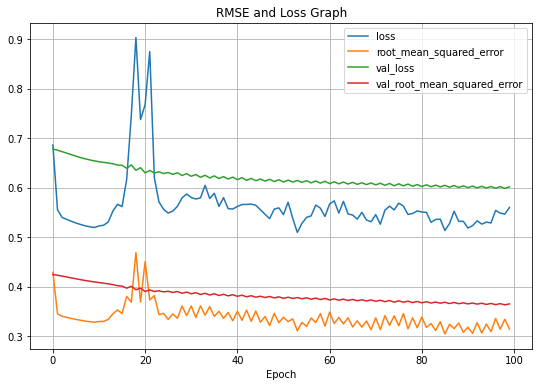

In [ ]:
pd.DataFrame(history.history).plot(figsize=(9,6))
plt.xlabel('Epoch')
plt.title('RMSE and Loss Graph')
plt.grid()

Reload the best model

In [ ]:
model = keras.models.load_model('model.tf')

Design the sample you want to predict

In [ ]:
user_id = d.user_id.sample(1).iloc[0]
item_bought_by_user = d.item_id[d.user_id == user_id].tolist()

a = d.item_id.unique()[~np.isin(d.item_id.unique(), item_bought_by_user)]
item_not_bought = [[i] for i in a]

user_item_array = np.hstack(
    ([[user_id]] * len(item_not_bought), item_not_bought)
)

Make predictions on sample users, on restaurants they have never visited

In [ ]:
ratings = model.predict(user_item_array).flatten()

## Recommendation

Issue 10 recommended items other than items that have been reviewed for user 49390 based on collaborative filtering

In [ ]:
print('Showing recommendations for user: {}'.format(user_id))
print('===' * 9)
print('Items with high ratings from user')
print('----' * 8)

a = d[['item_id','rating']][d.user_id == user_id].values

if len(a)>=10:
  user_and_rating = dict(sorted(a, key=lambda item: item[1], reverse=True))
  user_and_rating = dict(list(user_and_rating.items())[:10])
else:
  user_and_rating = dict(sorted(a, key=lambda item: item[1], reverse=True))

for i,j in user_and_rating.items():
    print('Item', int(i), '|', 'Rating :', j)
 
print('----' * 8)
print('Top 10 item recommendation and its rating prediction')
print('----' * 8)
 
top_ratings_indices = {i:ratings[i] for i in ratings.argsort()[-10:][::-1]}
a = {item_not_bought[i][0]:top_ratings_indices[i] for i in top_ratings_indices.keys()}
top_ratings_items = dict(sorted(a.items(), key=lambda item: item[1], reverse=True))

for i,j in top_ratings_items.items():
  j=j*(max_rating-min_rating)+min_rating
  print('Item', int(i), '|', 'Rating Prediction :', '%.2f'%j)

Showing recommendations for user: 49390
Items with high ratings from user
--------------------------------
Item 1435 | Rating : 5.0
Item 1560 | Rating : 5.0
Item 4627 | Rating : 5.0
Item 3259 | Rating : 5.0
Item 6378 | Rating : 5.0
Item 1919 | Rating : 4.0
Item 1767 | Rating : 4.0
Item 3338 | Rating : 4.0
Item 5453 | Rating : 4.0
Item 5383 | Rating : 4.0
--------------------------------
Top 10 item recommendation and its rating prediction
--------------------------------
Item 2513 | Rating Prediction : 4.89
Item 1647 | Rating Prediction : 4.89
Item 4968 | Rating Prediction : 4.87
Item 1715 | Rating Prediction : 4.85
Item 4576 | Rating Prediction : 4.85
Item 1136 | Rating Prediction : 4.83
Item 2016 | Rating Prediction : 4.82
Item 7721 | Rating Prediction : 4.82
Item 672 | Rating Prediction : 4.82
Item 993 | Rating Prediction : 4.81
